In [1]:
# 4.«Mode filter». Дан гауссов пучок диаметра w0, зашумлённый по амплитуде. Функцию шума придумать самому
# с возможностью перестройки характерной частоты шума.  Пучок фокусируется собирающей линзой, за которой 
# расположена апертура с диаметром D. За апертурой расположена коллимирующая линза. Определить оптимальное 
# положение апертуры и её диаметр. Критерий оптимальности —  отношение параметров качества пучка M2 до указанной 
# оптической системы и после неё. Размер пучка определять методом вторых моментов (по формуле эффективной 
# площади моды). Не советую делать разбиение мельче 1024х1024 точки.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.optimize import curve_fit

In [6]:
def gauss(R2, E0, w0):
    """Обычный гауссиан"""
    return  E0 * np.exp(-R2/w0**2)

def noise(R2 , depth, nu):
    """функция шума"""
    return (1 + depth*np.cos(np.sqrt(R2)*nu))

def to_gauss(R2, E0, w0,  depth, nu):
    """Зашумленный гауссиан"""
    return  gauss(R2, E0, w0) * noise(R2, depth, nu)


def fft2_proper(k_phi):
    """Расставляет результат Фурье-преобразования в правильном порядке"""
    N = k_phi.shape[0]
    k_phi_n = k_phi.copy()
    for i in range(0, N):
        for j in range (0, N):
            k_phi_n[i][j] = k_phi[(i + N//2)%N][(j + N//2)%N]
    return k_phi_n

def freq_proper(k):
    N = len(k)
    k_n = k.copy()
    for i in range(0, N):
        k_n[i] = k[(i + N//2) %N ]
    return k_n


def dif(k_phi, beta0, K2, z): #now assumes forward order
    """Дифракция в ходе распространения\n
       k_phi_n = k_phi * np.exp(1j * K2 /(2 * beta0) * z)
    """
    k_phi_n = k_phi * np.exp(1j * K2 /(2 * beta0) * z)
    return k_phi_n
    # return fft2_proper(k_phi_n)

def diafr(phi, R2, D):
    """Урезание пучка на диафрагме"""
    phi_n = phi * (R2 <= D**2)
    return phi_n

def lense(phi, R2, beta0, f):  #some questions with beta_0
    """Набег фазы после прохождения линзы \n
        phi_n = phi * np.exp(1j * beta0 * R2 / (2 * f))
    """
    phi_n = phi * np.exp(1j * beta0 * R2 / (2 * f))
    return phi_n       

def eff_w(phi, x):
    """Эффективная ширина пучка"""
    I = np.absolute(phi)**2
    I1 = simps([simps(x**2 * Ix, x) for Ix in I], x)
    I2 = simps([simps(Ix, x) for Ix in I], x)
    return 2 * np.sqrt(I1/I2)

def gauss_w(z, w0, z0, zR):
    """Форма распространения гауссовая пучка (для апроксимации)\n
        w(z) = w0 * np.sqrt(1 + ((z - z0)/zR)**2 )
    """
    return w0 * np.sqrt(1 + ((z - z0)/zR)**2 )

def zr(w0, lmbda):
    """ Длина рэлея при известной w0 и lmbda \n
    zr = w0**2 * np.pi/lmbda"""
    return w0**2 * np.pi/lmbda

In [13]:
# all plots, memory rewritten 
# system calculation

# Параметры пучка 
w0 = 0.5 * 1e-3
lmbda = 1030e-9
E0 = 1

# Рамка вычислений
N = 2**10
wN = 4 #сколько изначальных радиусов пучка укладывается в рамки вычислений
x = np.linspace(-wN*w0, wN*w0, N) # пространсвенная шкала
k = 2 * np.pi / (2 * w0 * wN) * np.linspace(-N/2, N/2 - 1, N) #k-пространство

# Параметры зашумления
depth = 0.1
nu = 1e5
                                     

# Параметры системы
f = 100e-3 #Фокусное расстояние
zD = f     #location of diaphragm
D = w0     #


def calc(zD, D, x, k,  E0, w0, lmbda , depth, nu, f, graph_out = 1, overwrite_zD = 1):
    """
    returns:
        \nM2 - M2 после прохождения системы
        \nwD - ширина пучка в диафрагме
        \nMf - M2 после первой линзы
        \nz0D - положение перетяжки после первой линзы (идеальное положение диафрагмы)
    """
    def graph(phi, s):
        if graph_out:
            fig, ax = plt.subplots(ncols = 2, nrows = 1)
            ax[0].imshow(np.absolute(phi))
            ax[1].plot(x, np.absolute(phi[N//2]))
            ax[1].set_xlim(-3*w0, 3*w0)
            plt.title(s)
            plt.xlim()

    beta0 = 2 * np.pi/lmbda
    zR = zr(w0, lmbda)
    M0 = lmbda/np.pi   #M2 изначального чисто гауссового пучка

    R2 = np.array([abs(x**2 + i**2) for i in x])
    K2 = np.array([abs(k**2 + i**2) for i in k])

    #field right before first lense
    #assume first lense is at the beam waist
    phi00 = to_gauss(R2, E0, w0, depth, nu)              # initial Field
    k_phi00 = fft2_proper(np.fft.fft2(phi00))            # initial FFT
    graph(phi00, 'before first lense')

    #propagating before first lense and calculating theta before 
    Zs1 = np.linspace(-2*zR, zR, 15)
    W1 = []
    for z in Zs1:
        k_phi_i = dif(k_phi00, beta0, K2, z )
        phi_i = np.fft.ifft2(fft2_proper(k_phi_i))
        W1.append(eff_w(phi_i, x))
    popt, pcov = curve_fit(gauss_w, Zs1, W1)

    theta1 = popt[0]/popt[2]    
    waist1 = popt[0]
    M1 = theta1 * waist1/M0  #M2 для зашумленного пучка до линзы
    #---------------------------------------------------
    if graph_out:
        fig, ax = plt.subplots()
        ZZs1 = np.linspace(Zs1[0], Zs1[-1], 100)
        plt.plot(ZZs1, gauss_w(ZZs1, *popt), label = "Апроксимация пучка")
        plt.plot(ZZs1, gauss_w(ZZs1, popt[0], popt[1], zr(popt[0], lmbda)), 'r--', label = "Гауссов пучок с теми же w0 и z0")
        plt.plot(Zs1, W1, 'ro',  label = "эффективная ширина")
        plt.title("Пучок до первой линзы")
        plt.legend()
        del ZZs1
    del Zs1, W1
    #---------------------------------------------------
       
    #pass the system
    phi0 = lense(phi00, R2, beta0, f)                   #Field after first lense
    k_phi0 = fft2_proper(np.fft.fft2(phi0))             #FFT after first lense
    graph(phi0, 'after first lense') 
    del phi0

    #calculate z0 after first lense
    Zsf = np.linspace(0, 2 * f, 15)
    Wf = []
    for z in Zsf:
        k_phi_i = dif(k_phi0, beta0, K2, z )
        phi_i = np.fft.ifft2(fft2_proper(k_phi_i))
        Wf.append(eff_w(phi_i, x))
    popt, pcov = curve_fit(gauss_w, Zsf, Wf)

    # Поставим диафрагму в перетяжку после первой линзы
    wD = popt[0] #width at diaphragm
    z0D = popt[1]
    if overwrite_zD:
        zD = popt[1] #assign zD = z0 , change when calclating foe different zD
    print(f'f = {f}, z0 = {zD}')

    # Парамтеры пучка после первой линзы
    thetaf = popt[0]/popt[2]
    waistf = popt[0]
    Mf = thetaf * waistf/M0
    #---------------------------------------------------
    if graph_out:
        fig, ax = plt.subplots()
        ZZsf = np.linspace(Zsf[0], Zsf[-1], 100)
        plt.plot(ZZsf, gauss_w(ZZsf, *popt), label = "Апроксимация пучка")
        plt.plot(ZZsf, gauss_w(ZZsf, popt[0], popt[1], zr(popt[0], lmbda)), 'r--',label = "Гауссов пучок с теми же w0 и z0")
        plt.plot(Zsf, Wf, 'ro', label = "эффективная ширина")
        plt.title("После первой линзы")
        del ZZsf
    del Zsf, Wf
    #---------------------------------------------------


    k_phi1 = dif(k_phi0, beta0, K2, zD )                #FFT before diaphragm
    del k_phi0
    phi1 = np.fft.ifft2(fft2_proper(k_phi1))            #Field before diaphragm
    del k_phi1
    graph(phi1, 'before diaphragm')

    phi2 = diafr(phi1, R2, D)                           #Field after diaphragm
    del phi1
    k_phi2 = fft2_proper(np.fft.fft2(phi2))             #FFT after diaphragm
    graph(phi2, 'after diaphragm')
    del phi2

    k_phi3 = dif(k_phi2, beta0, K2, 2*f - zD)            #FFt before second lense
    del k_phi2
    phi3 = np.fft.ifft2(fft2_proper(k_phi3))            #Field before second lense
    del k_phi3
    graph(phi3, 'before second lense')
   
    phi4 = lense(phi3, R2, beta0, f)                    #FFt after second lense
    del phi3
    k_phi4 = fft2_proper(np.fft.fft2(phi4))             #Field after second lense
    graph(phi4, 'after second lense')
    del phi4


    #after the system
    Zs2 = np.linspace(0, 4 * f, 10)
    W2 = []
    # phis2 = []
    for z in Zs2:
        k_phi_i = dif(k_phi4, beta0, K2, z )
        phi_i = np.fft.ifft2(fft2_proper(k_phi_i))
        W2.append(eff_w(phi_i, x))
       
    graph(phi_i, str(Zs2[-1]))

    popt, pcov = curve_fit(gauss_w, Zs2, W2)
    # Параметры пучка после второй линзы
    theta2 = popt[0]/popt[2]
    waist2 = popt[0]
    M2 = theta2 * waist2 / M0
    #---------------------------------------------------
    if graph_out:
        fig, ax = plt.subplots()
        ZZs2 = np.linspace(Zs2[0], Zs2[-1], 100)
        plt.plot(ZZs2, gauss_w(ZZs2, *popt), label = "Апроксимация пучка")
        plt.plot(ZZs2, gauss_w(ZZs2, popt[0], popt[1], zr(popt[0], lmbda)), 'r--', label = "Гауссов пучок с теми же w0 и z0")
        plt.plot(Zs2, W2, 'ro', label = "эффективная ширина")
        plt.title("После второй линзы")
        del ZZs2
    del Zs2, W2
    #---------------------------------------------------
    print(f'D = {D}\
          \nM1 = {M1}, theta1 = {theta1}, waist1 = {waist1}\
          \nM2 = {M2}, theta2 = {theta2}, waist2 = {waist2}\
          \nM2/M1 = {M2/M1}')
    
    return M2, wD, Mf, z0D


In [ ]:

params = [x, k,  E0, w0, lmbda , depth, nu, f]
print(calc(zD, D, *params))


f = 0.1, z0 = 0.09220165310092246
D = 0.0001          
M1 = 1.1739908617512793, theta1 = 0.0006476294478210991, waist1 = 0.0005943270272952929          
M2 = 1.1700153653901075, theta2 = 0.0007158427222363966, waist2 = 0.0005358722937433893          
M2/M1 = 0.9966136905399405
f = 0.1, z0 = 0.09220165310092246
D = 0.00015555555555555554          
M1 = 1.1739908617512793, theta1 = 0.0006476294478210991, waist1 = 0.0005943270272952929          
M2 = 1.0044204938183545, theta2 = 0.0006642446708843962, waist2 = 0.0004957638302488378          
M2/M1 = 0.8555607428834912
f = 0.1, z0 = 0.09220165310092246
D = 0.00021111111111111108          
M1 = 1.1739908617512793, theta1 = 0.0006476294478210991, waist1 = 0.0005943270272952929          
M2 = 1.0029347123421202, theta2 = 0.000663342998924267, waist2 = 0.0004957033626535584          
M2/M1 = 0.8542951610764761
f = 0.1, z0 = 0.09220165310092246
D = 0.0002666666666666666          
M1 = 1.1739908617512793, theta1 = 0.0006476294478210991, waist1 =

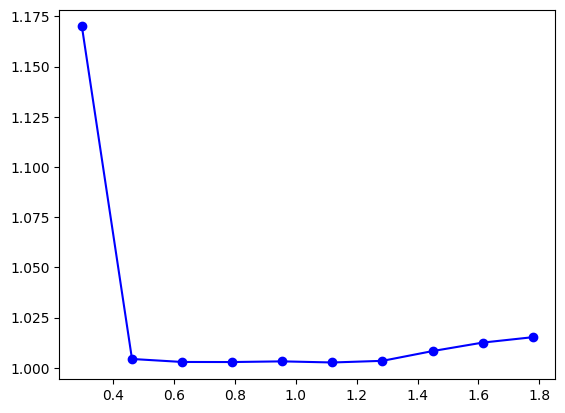

In [15]:
# all plots, memory rewritten 
# system calculation

w0 = 0.5 * 1e-3
lmbda = 1030e-9
f = 100e-3
E0 = 1

N = 2**9
wN = 4

depth = 0.2
nu = 1e7
                                     

x = np.linspace(-wN*w0, wN*w0, N)
k = 2 * np.pi / (2 * w0 * wN) * np.linspace(-N/2, N/2 - 1, N)


zD = f     #location of diaphragm
D = w0     #

params = [x, k,  E0, w0, lmbda , depth, nu, f]
DD = np.linspace(0.0001,0.0006, 10)
# DD = np.linspace(0.0001,0.0003, 5)
MM = []
WD = 0
MF = 0
for D in DD:
    a = calc(zD, D, *params, graph_out=0)
    MM.append(a[0])
    WD = a[1]
    MF = a[2]


fig, ax = plt.subplots()
plt.plot(DD/WD, MM, 'bo-')
print(f'waist diameter {WD}, M2 between lenses {MF}')


f = 0.1, z0 = 0.1
D = 0.0002          
M1 = 1.1739908617512793, theta1 = 0.0006476294478210991, waist1 = 0.0005943270272952929          
M2 = 0.962800783144553, theta2 = 0.0006362812353342146, waist2 = 0.0004961062190771876          
M2/M1 = 0.8201092653381582
f = 0.1, z0 = 0.2


c:\Users\vika\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\vika\AppData\Local\Temp\ipykernel_10332\1521389773.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


D = 0.0002          
M1 = 1.1739908617512793, theta1 = 0.0006476294478210991, waist1 = 0.0005943270272952929          
M2 = -0.00040564250214108723, theta2 = -0.0025809033672164554, waist2 = 5.1529871647968115e-08          
M2/M1 = -0.00034552441194983193
waist diameter 0, M2 between lenses 0


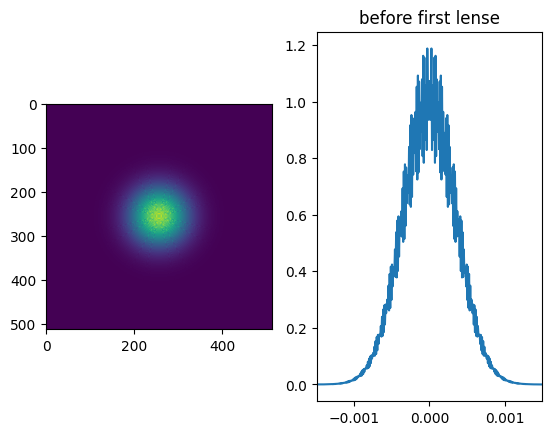

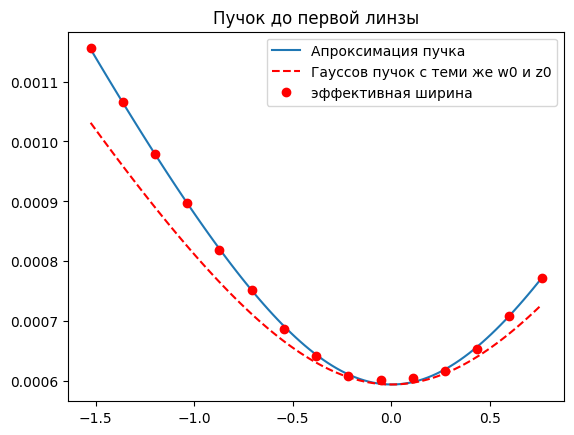

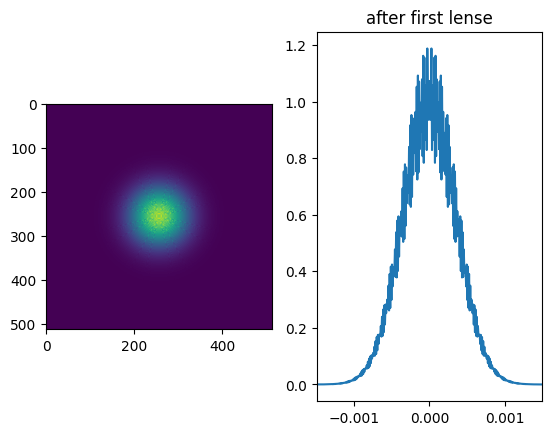

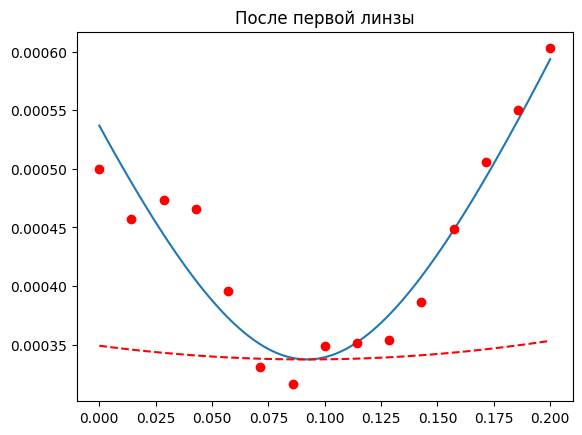

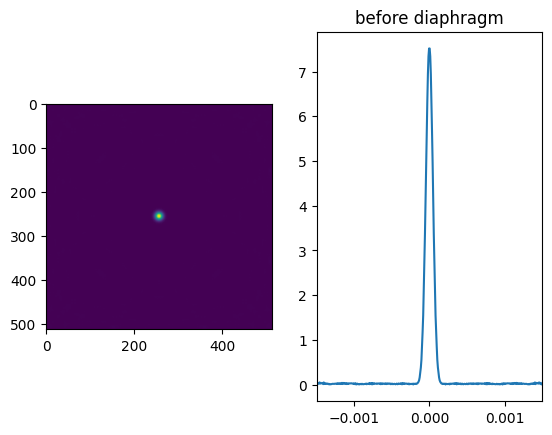

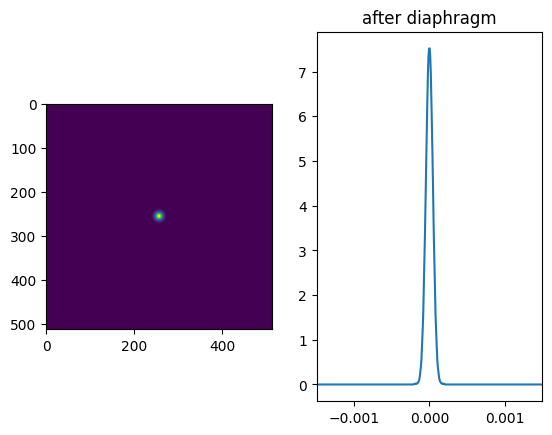

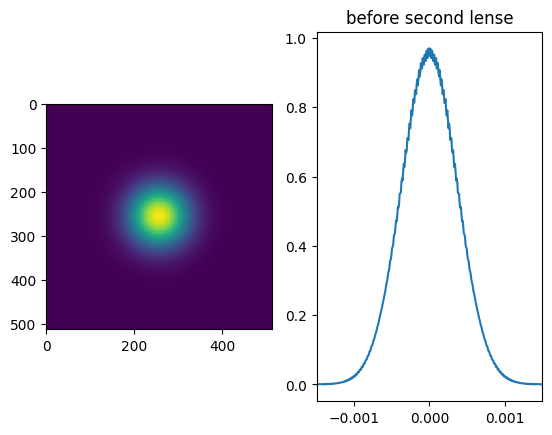

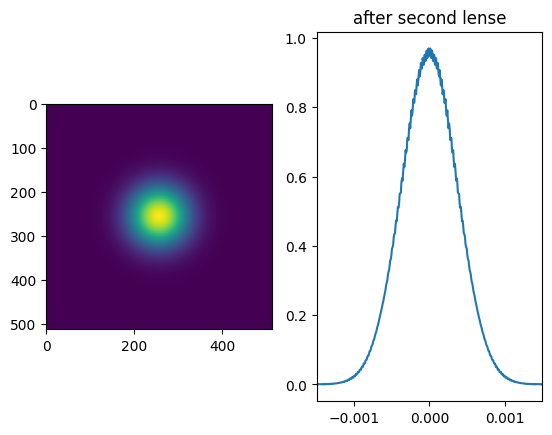

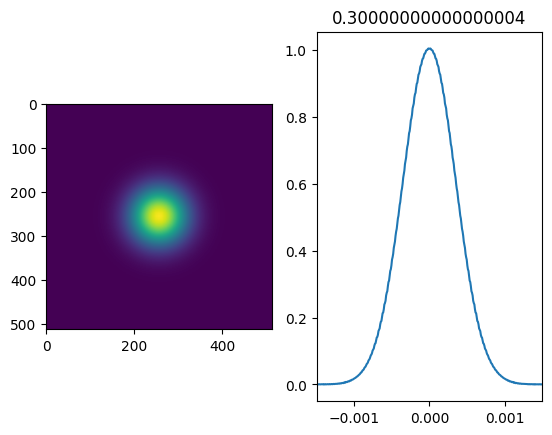

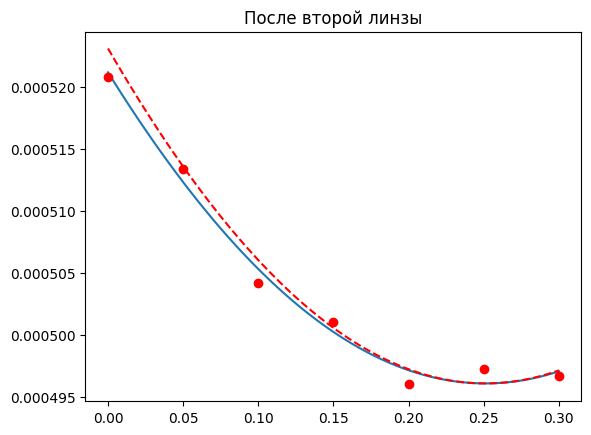

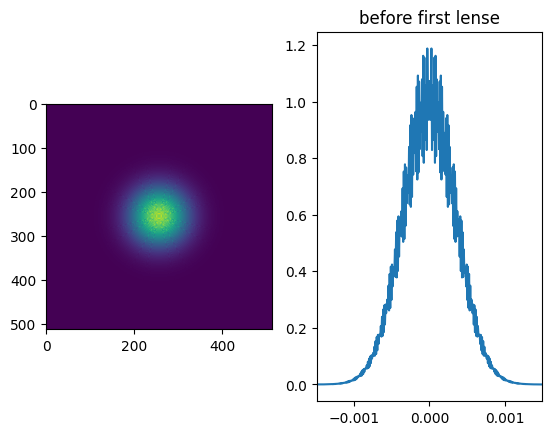

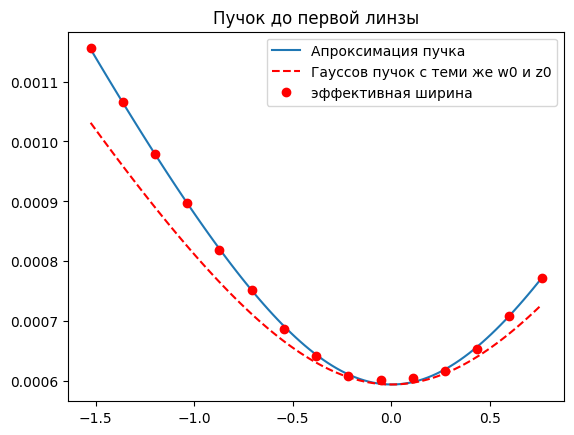

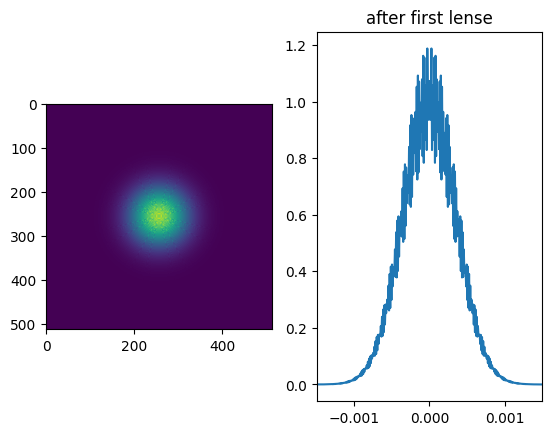

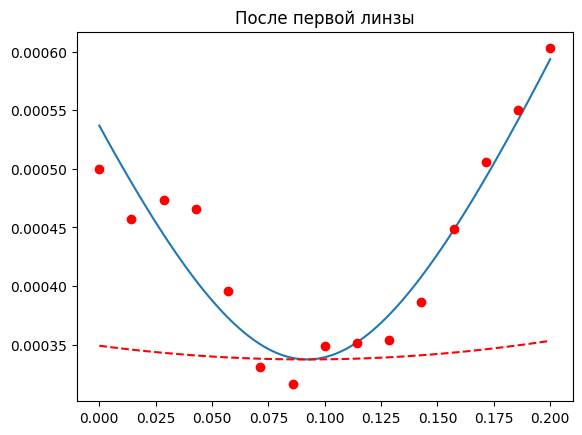

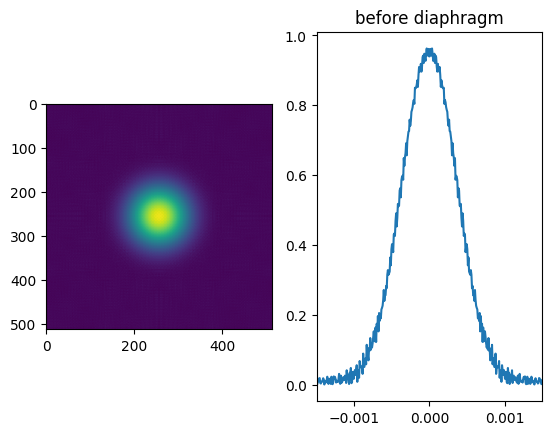

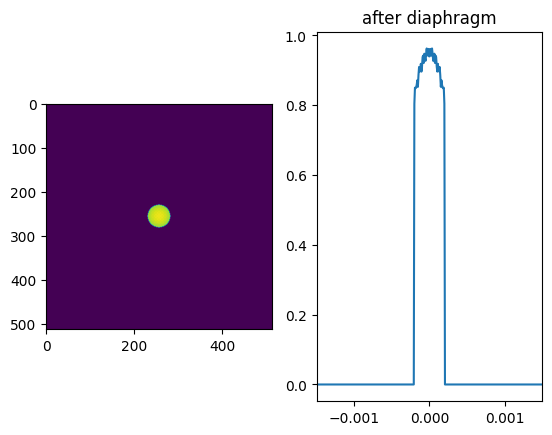

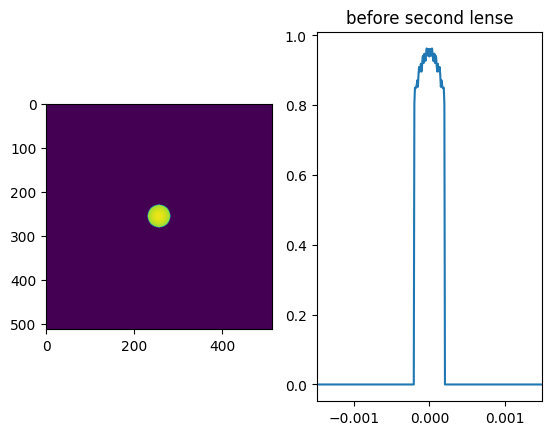

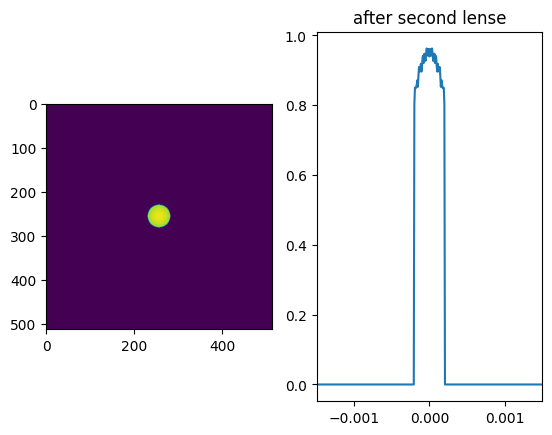

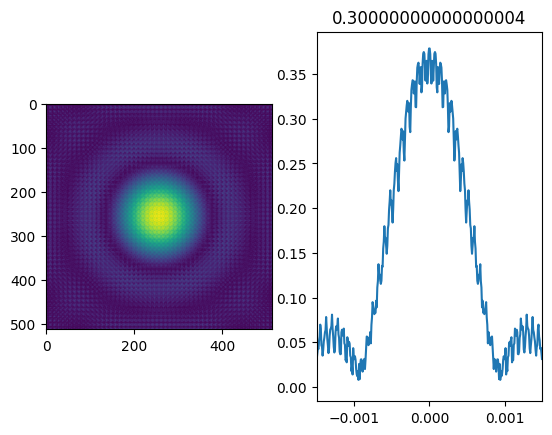

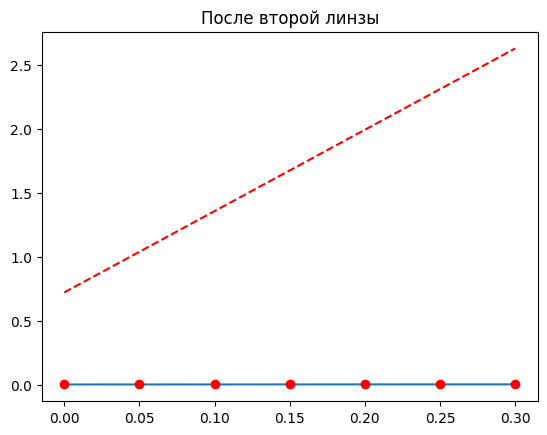

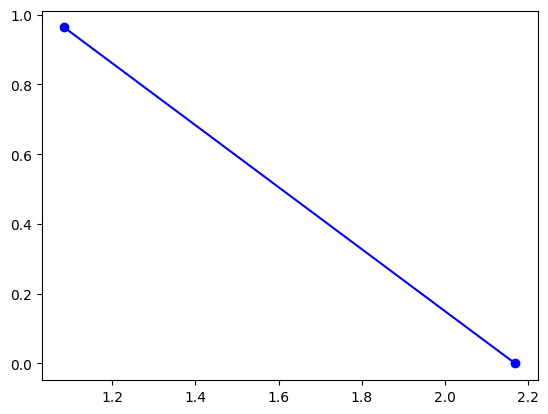

In [11]:
# all plots, memory rewritten 
# system calculation






w0 = 0.5 * 1e-3
lmbda = 1030e-9
f = 100e-3
E0 = 1

N = 2**9
wN = 4

depth = 0.2
nu = 1e7
                                     

x = np.linspace(-wN*w0, wN*w0, N)
k = 2 * np.pi / (2 * w0 * wN) * np.linspace(-N/2, N/2 - 1, N)



D = 0.0002    #optimum from previous calculation

params = [x, k,  E0, w0, lmbda , depth, nu, f]
zDD = np.linspace(f, 2*f, 2)
MM = []
WD = 0
MF = 0
for zD in zDD:
    a = calc(zD, D, *params, overwrite_zD = 0)
    MM.append(a[0])
    Z0 = a[3]


fig, ax = plt.subplots()
plt.plot(zDD/Z0, MM, 'bo-')
print(f'waist diameter {WD}, M2 between lenses {MF}')
